In [1]:
import pandas as pd
import numpy as np 

import yfinance as yf
import mplfinance as mpf

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

### Initial Questions:

- Does BTC's price have a correlation with the DJI?
- Does BTC's price have a relationship with Gold?
- How does the volatility of BTC compare with that of the DJI and Gold?

## Acquire 

In [2]:
def asset_price(year):
    btc = "BTC-USD"
    btc_df = yf.download(btc, start=f"{year}-01-01", end="2023-2-13")

    gold = "GC=F"
    gold_df = yf.download(gold, start=f"{year}-01-01", end="2023-2-13")

    dji = "^DJI"
    dji_df = yf.download(dji, start=f"{year}-01-01", end="2023-2-13")
    
    return btc_df, gold_df, dji_df

In [3]:
def merged_assets(btc_df, gold_df, dji_df):
    
    df_btc_gold = pd.merge(btc_df['Adj Close'], gold_df['Adj Close'], on="Date")

    df = pd.merge(df_btc_gold, dji_df['Adj Close'], on="Date")
    
    return df

In [4]:
# specify the stock symbol
btc = "BTC-USD"

# retrieve the historical data
btc_df = yf.download(btc, start="2010-01-01", end="2023-2-13")
btc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,22939.398438,25371367758
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,21819.039062,32572572185
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,21651.183594,27078406594


In [5]:
# specify the stock symbol
gold = "GC=F"

# retrieve the historical data
gold_df = yf.download(gold, start="2010-01-01", end="2023-2-13")
gold_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,1117.699951,184
2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,1118.099976,53
2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,1135.900024,363
2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,1133.099976,56
2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,1138.199951,54
...,...,...,...,...,...,...
2023-02-06,1865.599976,1880.000000,1863.400024,1866.199951,1866.199951,424
2023-02-07,1870.000000,1875.699951,1868.000000,1871.699951,1871.699951,297
2023-02-08,1872.099976,1880.400024,1872.099976,1877.400024,1877.400024,230


In [6]:
# specify the stock symbol
dji = "^DJI"

# retrieve the historical data
dji_df = yf.download(dji, start="2010-01-01", end="2023-2-13")
dji_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10604.969727,10430.690430,10583.959961,10583.959961,179780000
2010-01-05,10584.559570,10584.559570,10522.519531,10572.019531,10572.019531,188540000
2010-01-06,10564.719727,10594.990234,10546.549805,10573.679688,10573.679688,186040000
2010-01-07,10571.110352,10612.370117,10505.209961,10606.860352,10606.860352,217390000
2010-01-08,10606.400391,10619.400391,10554.330078,10618.190430,10618.190430,172710000
...,...,...,...,...,...,...
2023-02-06,33874.441406,33962.839844,33683.578125,33891.019531,33891.019531,296400000
2023-02-07,33769.781250,34240.000000,33634.101562,34156.691406,34156.691406,361620000
2023-02-08,34132.898438,34161.648438,33899.789062,33949.011719,33949.011719,324090000


In [7]:
df_btc_gold = pd.merge(btc_df['Adj Close'], gold_df['Adj Close'], on="Date")

In [8]:
df_btc_gold

,Adj Close_x,Adj Close_y
Date,,
2014-09-17,457.334015,1234.400024
2014-09-18,424.440002,1225.699951
2014-09-19,394.795990,1215.300049
2014-09-22,402.152008,1216.800049
2014-09-23,435.790985,1221.000000
...,...,...
2023-02-06,22760.109375,1866.199951
2023-02-07,23264.291016,1871.699951
2023-02-08,22939.398438,1877.400024


In [9]:
df = pd.merge(df_btc_gold, dji_df['Adj Close'], on="Date")

## Prepare

In [10]:
def clean_df(df):
    '''
    
    '''
    df.rename(columns= {'Adj Close_x': 'btc_price',
                        'Adj Close_y': 'gold_price',
                        'Adj Close': 'dji_price'}, inplace = True )
    
    df.index.name = 'date'

    max_date = pd.Timestamp('2022-12-31')
    df = df[df.index <= max_date]
    
    df = df.round(2)
    
    df_year = df.resample('Y').mean()
    df_month = df.resample('M').mean()
    df_quarter = df.resample('3M').mean()
    
    df_year = df_year.round(2)
    df_month = df_month.round(2)
    df_quarter = df_quarter.round(2)
    
    return df, df_year, df_month, df_quarter

In [11]:
df.rename(columns= {'Adj Close_x': 'btc_price',
                    'Adj Close_y': 'gold_price',
                    'Adj Close': 'dji_price'}, inplace = True )

In [12]:
df.index.name = 'date'

In [13]:
max_date = pd.Timestamp('2022-12-31')

df = df[df.index <= max_date]

In [14]:
df

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.334015,1234.400024,17156.849609
2014-09-18,424.440002,1225.699951,17265.990234
2014-09-19,394.795990,1215.300049,17279.740234
2014-09-22,402.152008,1216.800049,17172.679688
2014-09-23,435.790985,1221.000000,17055.869141
...,...,...,...
2022-12-23,16796.953125,1795.900024,33203.929688
2022-12-27,16717.173828,1814.800049,33241.558594
2022-12-28,16552.572266,1807.900024,32875.710938


In [15]:
df.isna().sum()

btc_price     0
gold_price    0
dji_price     0
dtype: int64

In [16]:
df.index.dtype

dtype('<M8[ns]')

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
btc_price,2085.0,12886.055939,16212.890916,178.102997,673.106018,7116.804199,16830.341797,67566.828125
gold_price,2085.0,1453.485275,272.686302,1050.800049,1229.500000,1319.300049,1750.000000,2051.500000
dji_price,2085.0,25038.530906,6011.734093,15660.179688,18516.550781,25090.480469,29591.269531,36799.648438


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2085 entries, 2014-09-17 to 2022-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   btc_price   2085 non-null   float64
 1   gold_price  2085 non-null   float64
 2   dji_price   2085 non-null   float64
dtypes: float64(3)
memory usage: 65.2 KB


In [19]:
df = df.round(2)
df.head(3)

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.33,1234.4,17156.85
2014-09-18,424.44,1225.7,17265.99
2014-09-19,394.80,1215.3,17279.74


In [20]:
df_year = df.resample('Y').mean()
df_month = df.resample('M').mean()
df_quarter = df.resample('3M').mean()

In [21]:
df_year = df_year.round(2)
df_month = df_month.round(2)
df_quarter = df_quarter.round(2)

In [22]:
df_year

,btc_price,gold_price,dji_price
date,,,
2014-12-31,365.86,1203.70,17315.96
2015-12-31,272.43,1158.84,17587.09
2016-12-31,567.30,1249.71,17921.82
2017-12-31,3994.76,1257.70,21750.20
2018-12-31,7544.71,1267.60,25048.41
2019-12-31,7405.02,1392.72,26379.54
2020-12-31,11147.77,1773.16,26890.67
2021-12-31,47515.75,1797.67,34055.29
2022-12-31,28209.53,1800.07,32897.35


## Split Data

In [23]:
def split_data_explore(df):
    '''
    
    '''
    train_size = int(round(df.shape[0] * 0.5))
    validate_size = int(round(df.shape[0] * 0.3))
    test_size = int(round(df.shape[0] * 0.2))
    
    
    validate_end_index = train_size + validate_size
    
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]

    
    return train, validate, test

In [24]:
train, validate, test = split_data_explore(df)

In [25]:
df.shape

(2085, 3)

In [26]:
train_size = int(round(df.shape[0] * 0.5))
validate_size = int(round(df.shape[0] * 0.3))
test_size = int(round(df.shape[0] * 0.2))
train_size, validate_size, test_size

(1042, 626, 417)

In [27]:
len(df) == train_size + validate_size + test_size


True

In [28]:
validate_end_index = train_size + validate_size
validate_end_index

1668

In [29]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [30]:
train.shape[0], validate.shape[0], test.shape[0]

(1042, 626, 417)

In [31]:
len(train) + len(validate) + len(test) == len(df)

True

## Explore

In [32]:
df

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.33,1234.4,17156.85
2014-09-18,424.44,1225.7,17265.99
2014-09-19,394.80,1215.3,17279.74
2014-09-22,402.15,1216.8,17172.68
2014-09-23,435.79,1221.0,17055.87
...,...,...,...
2022-12-23,16796.95,1795.9,33203.93
2022-12-27,16717.17,1814.8,33241.56
2022-12-28,16552.57,1807.9,32875.71


In [33]:
def plot(df):
    '''
    This function is to graph all columns within the df
    '''
    df.plot()
    plt.title('Comparing Price Between Assets')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(['BTC','GOLD', 'DJI'])
    plt.show()

<AxesSubplot:xlabel='date'>

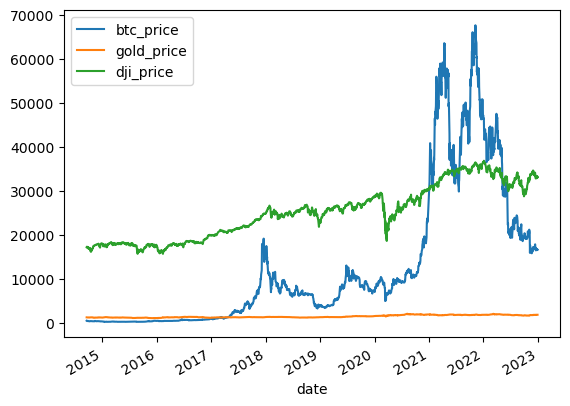

In [34]:
df.plot()

<AxesSubplot:xlabel='date'>

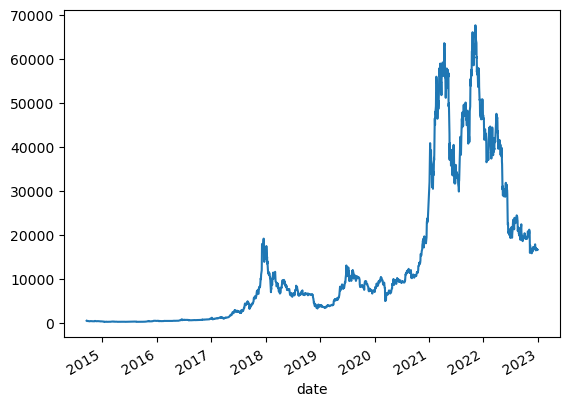

In [35]:
df['btc_price'].plot()

<AxesSubplot:xlabel='date'>

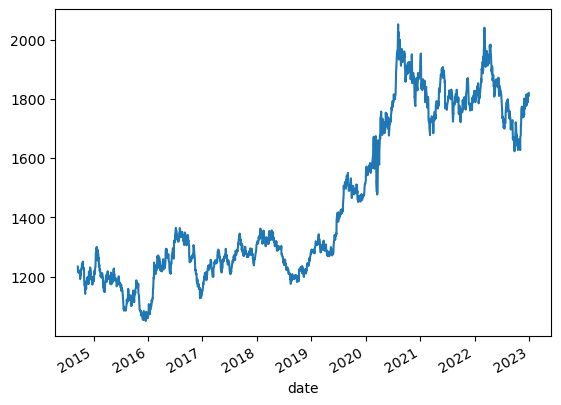

In [36]:
df['gold_price'].plot()

<AxesSubplot:xlabel='date'>

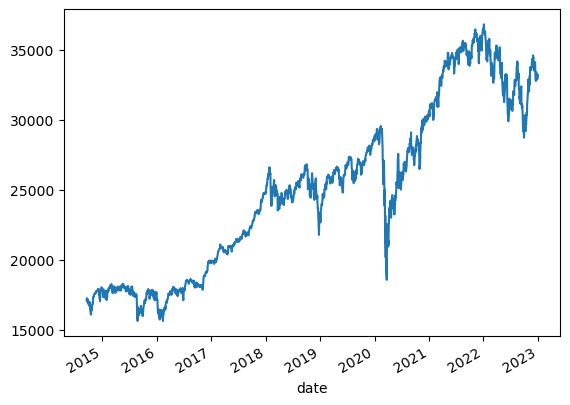

In [37]:
df['dji_price'].plot()

In [38]:
def line_plot(train):
    for col in train.columns:
        plt.figure(figsize=(14,8))
        plt.plot(train[col], color='#377eb8', label = 'Train')
        plt.plot(validate[col], color='#ff7f00', label = 'Validate')
        plt.plot(test[col], color='#4daf4a', label = 'Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'{col[:3]}')
        plt.show()   

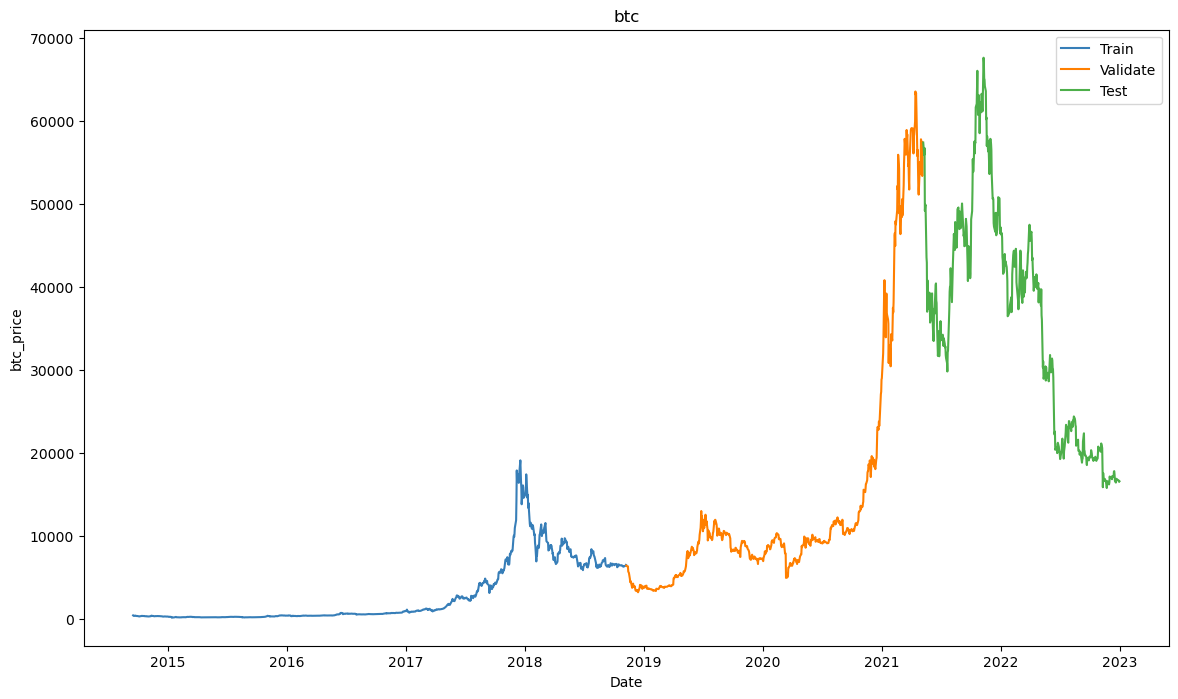

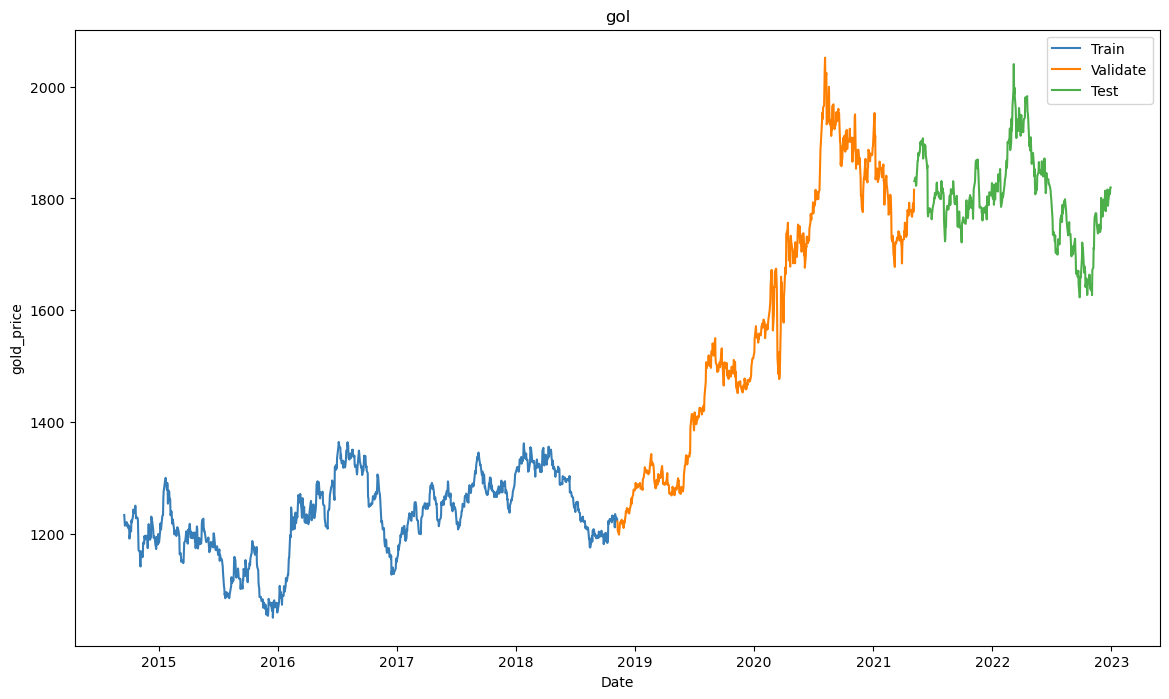

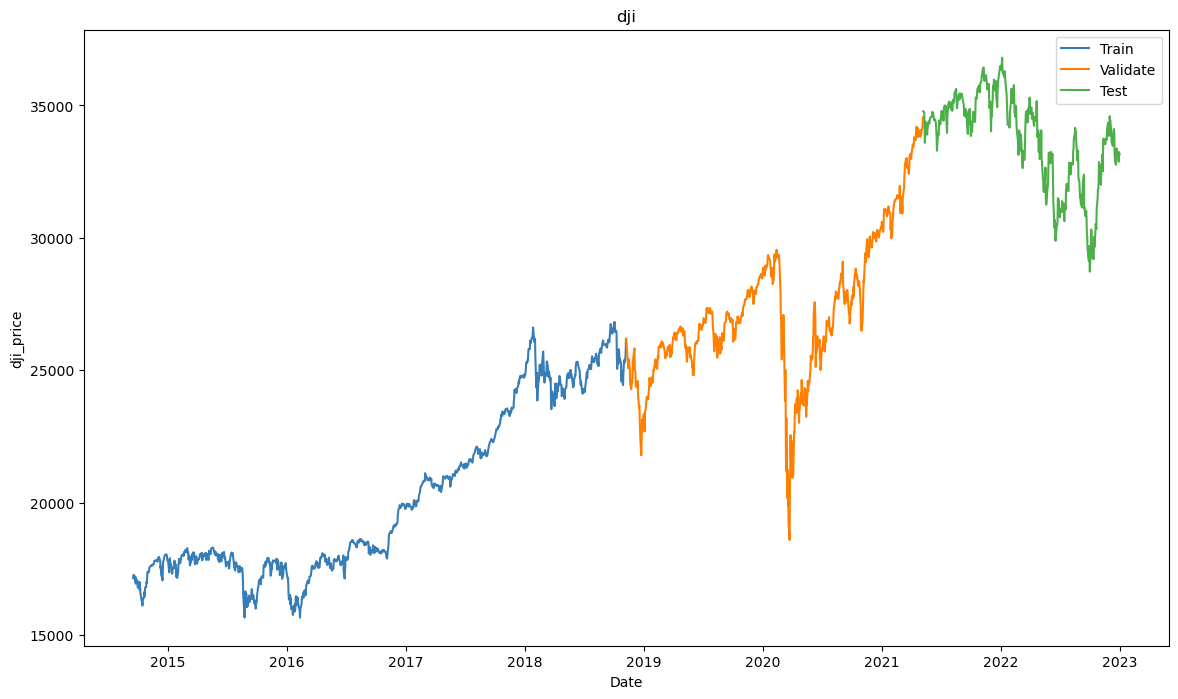

In [39]:
line_plot(train)

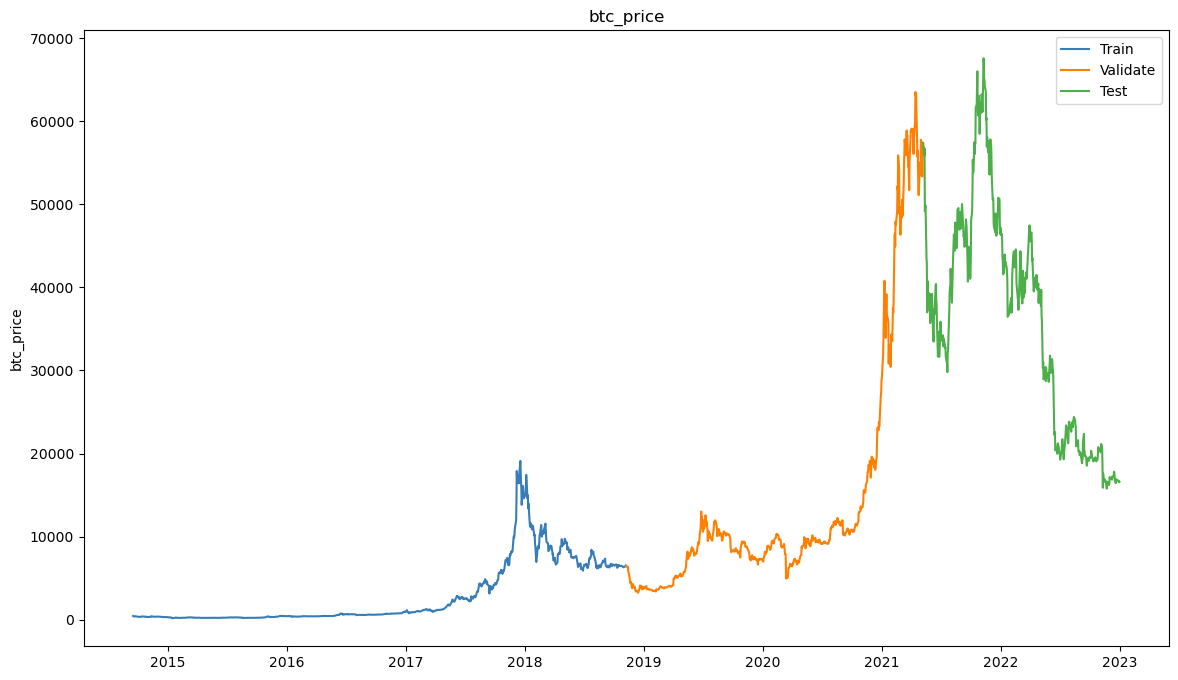

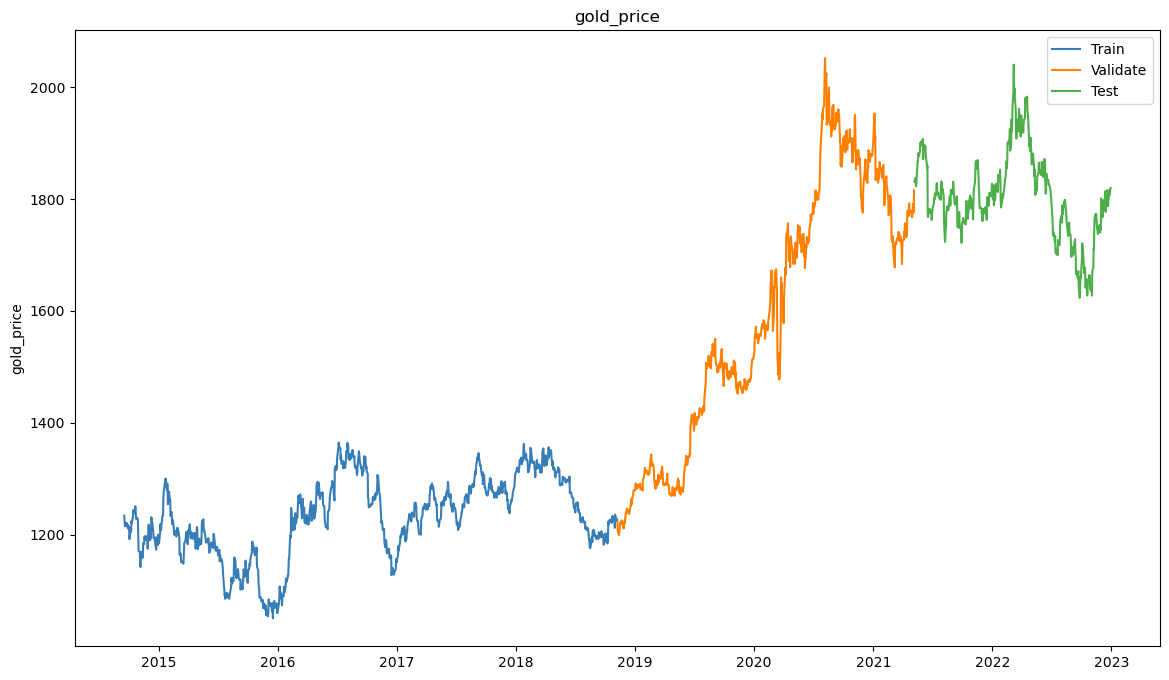

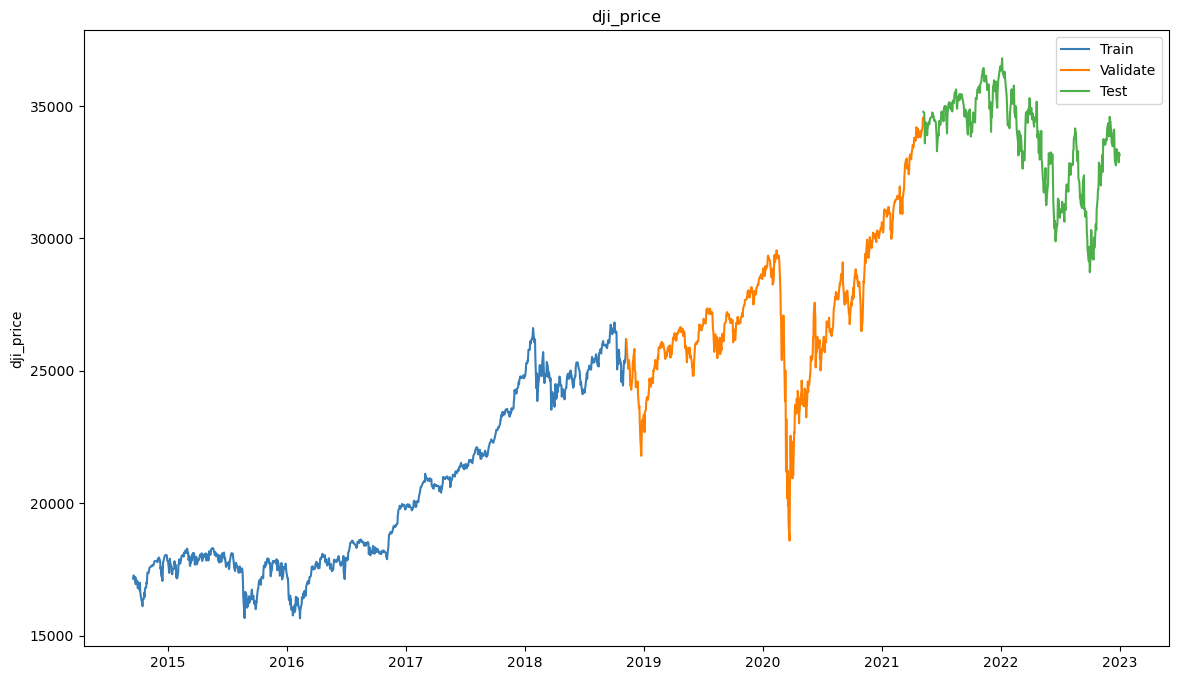

In [40]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

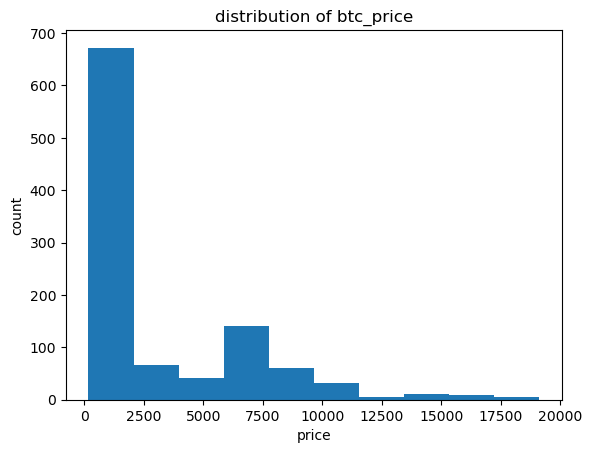

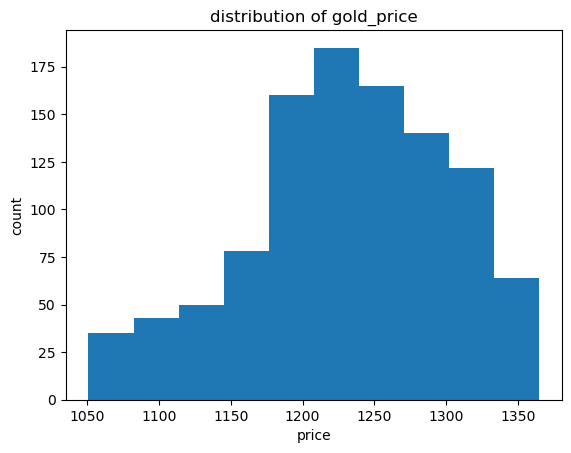

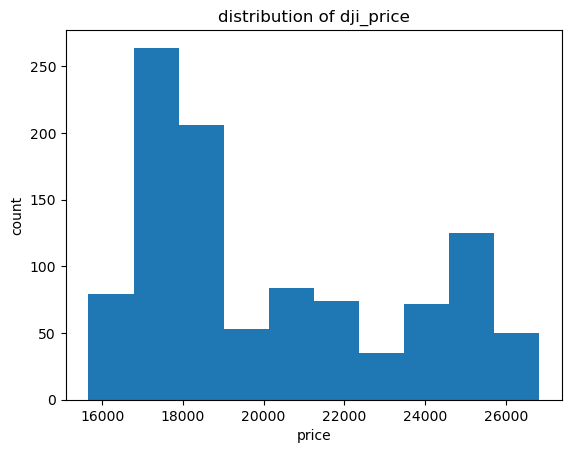

In [41]:
for i in train.columns:
    plt.hist(train[i])
    plt.xlabel('price')
    plt.ylabel('count')
    plt.title(f'distribution of {i}')
    plt.show()

In [42]:
month_mean = train['btc_price'].resample('M').mean()
month_mean = pd.DataFrame(month_mean)

month_mean['shifted'] = month_mean['btc_price'].shift(-1)
month_mean.head()

,btc_price,shifted
date,,
2014-09-30,411.611000,365.888696
2014-10-31,365.888696,369.204737
2014-11-30,369.204737,342.159091
2014-12-31,342.159091,248.440000
2015-01-31,248.440000,232.495263


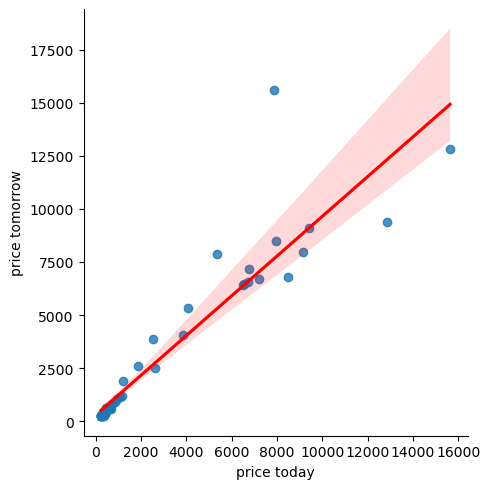

In [43]:
sns.lmplot(data = month_mean, x = 'btc_price', y = 'shifted', line_kws= {'color': 'red'})
plt.xlabel('price today')
plt.ylabel('price tomorrow')
plt.show()

In [44]:
def seasonal_charts(train):
    '''
    This function takes in the train dataset and runs a for loop to look at the trends and seasons of the vairables
    '''
    for col in train.columns:
        result = sm.tsa.seasonal_decompose(train[col].resample('M').mean())
        result.plot()
        plt.show()

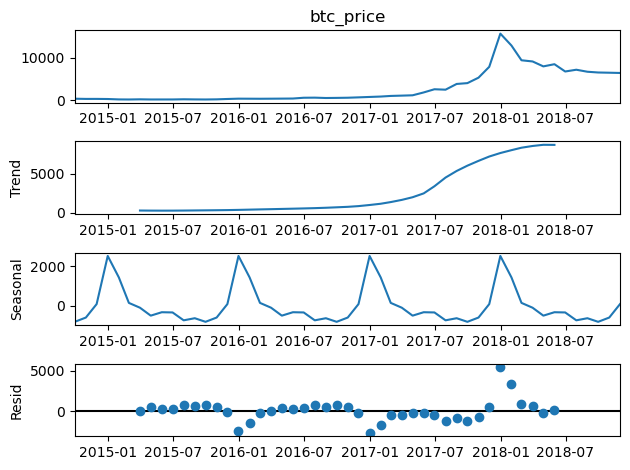

In [45]:
result = sm.tsa.seasonal_decompose(train['btc_price'].resample('M').mean())

result.plot()
plt.show()

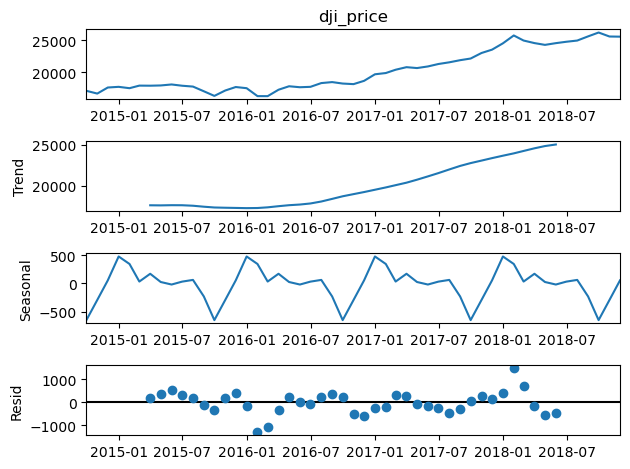

In [46]:
result = sm.tsa.seasonal_decompose(train['dji_price'].resample('M').mean())

result.plot()
plt.show()

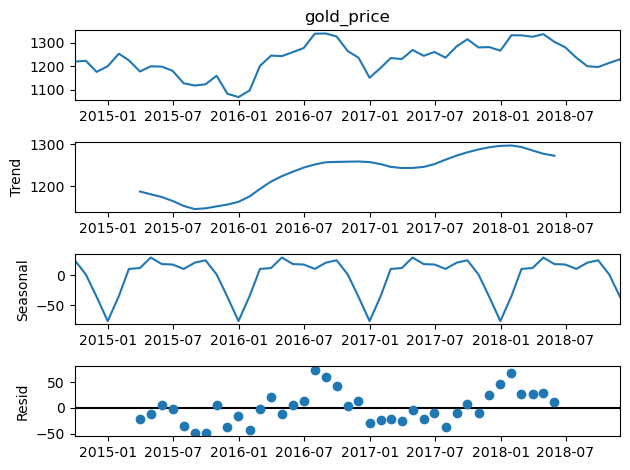

In [47]:
result = sm.tsa.seasonal_decompose(train['gold_price'].resample('M').mean())

result.plot()
plt.show()

### **1. Does BTC's price have a correlation with the DJI?**

<AxesSubplot:xlabel='date'>

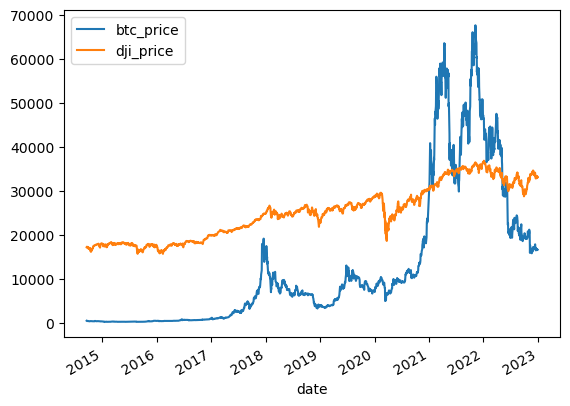

In [48]:
df[['btc_price','dji_price']].plot()

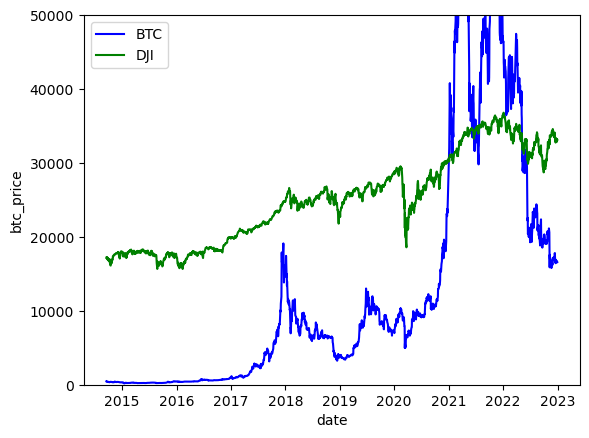

In [49]:
sns.lineplot(data=df, x='date', y='btc_price', color='blue', label='BTC')
sns.lineplot(data=df, x='date', y='dji_price', color='green', label='DJI')
plt.ylim(0,50000)
plt.legend()
plt.show()

$H_0$: There is no correlation between the BTC and DJI price

$H_a$: There is a correlation between the BTC and DJI price

$\alpha$ = 0.05

In [50]:
α = 0.05
# Calculate the Pearson's correlation coefficient
r, p = pearsonr(df['btc_price'], df['dji_price'])

print("Pearson's correlation coefficient:", r)
print("p-value:", p)

if p < α:
    print('We reject the null hypothesis') 
else:
    print('We fail to reject the null hypothesis')

Pearson's correlation coefficient: 0.8560544423948482
p-value: 0.0
We reject the null hypothesis


In [51]:
def pearsons_test(df, col1, col2):
    '''
    This function takes in a df and 2 col names to run a pearson's stats test
    '''
    α = 0.05
    # Calculate the Pearson's correlation coefficient
    r, p = pearsonr(df[col1], df[col2])

    print("Pearson's correlation coefficient:", r)
    print("p-value:", p)

    if p < α:
        print('We reject the null hypothesis') 
    else:
        print('We fail to reject the null hypothesis')

In [52]:
pearsons_test(df, 'btc_price', 'dji_price')

Pearson's correlation coefficient: 0.8560544423948482
p-value: 0.0
We reject the null hypothesis


In [53]:
pearsons_test(df, 'btc_price', 'gold_price')

Pearson's correlation coefficient: 0.7642495379265786
p-value: 0.0
We reject the null hypothesis


**Takeaways**

We reject the null hypothesis meaning there is a correlation between the DJI and BTC price. There is a strong correlation to be specific.

### **2. Does BTC's price have a relationship with Gold?** 

In [54]:
def comparing_assets(df, y1, y2):
    '''
    This function takes in a dataframe and plots 2 columns 
    '''
    sns.lineplot(data=df, x='date', y= y1, color='blue', label='BTC')
    
    y2_label = y2.split('_')[0].upper()
    
    sns.lineplot(data=df, x='date', y= y2, color='green', label= y2_label)
    plt.ylim(0,50000)
    plt.title(f"BTC Compared To {y2_label} Price")
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.show()

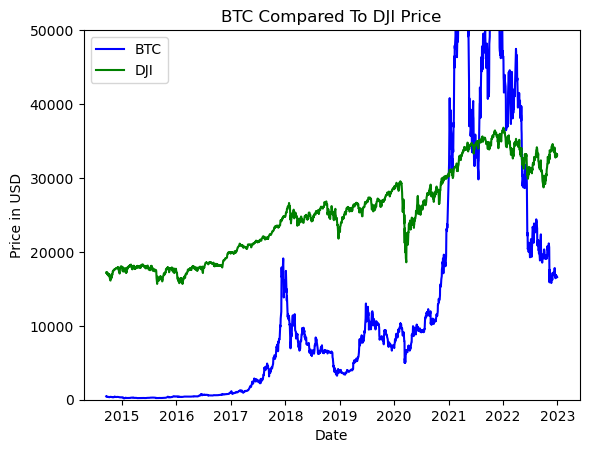

In [55]:
comparing_assets(df, 'btc_price', 'dji_price')

<AxesSubplot:xlabel='date'>

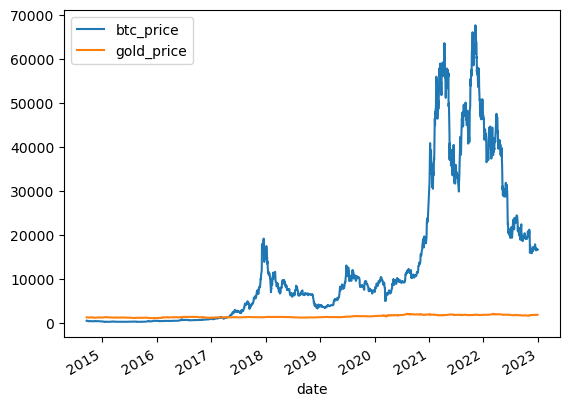

In [56]:
df[['btc_price','gold_price']].plot()

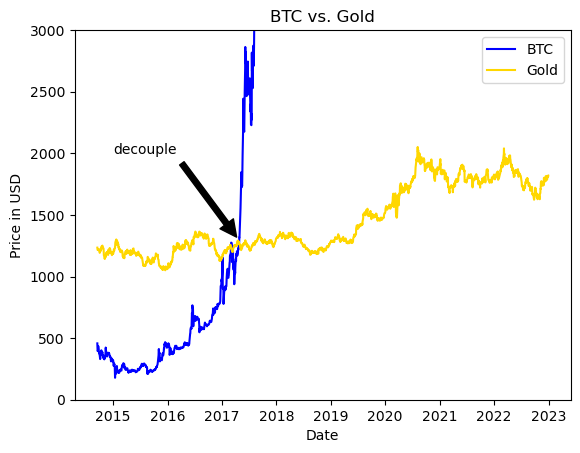

In [57]:
sns.lineplot(data=df, x='date', y='btc_price', color='blue', label='BTC')
sns.lineplot(data=df, x='date', y='gold_price', color='gold' ,label='Gold')
plt.annotate(text = 'decouple', xy = (pd.Timestamp('2017-04-30'),1285), xytext = (pd.Timestamp('2015'), 2000),
                 arrowprops = dict(facecolor = 'black', shrink = 0.05))
plt.ylim(0,3000)
plt.title('BTC vs. Gold')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

In [58]:
def zoomed_in(df):
    sns.lineplot(data=df, x='date', y='btc_price', color='blue', label='BTC')
    sns.lineplot(data=df, x='date', y='gold_price', color='gold' ,label='Gold')
    plt.ylim(0,3000)
    plt.title('BTC vs. Gold')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.show()

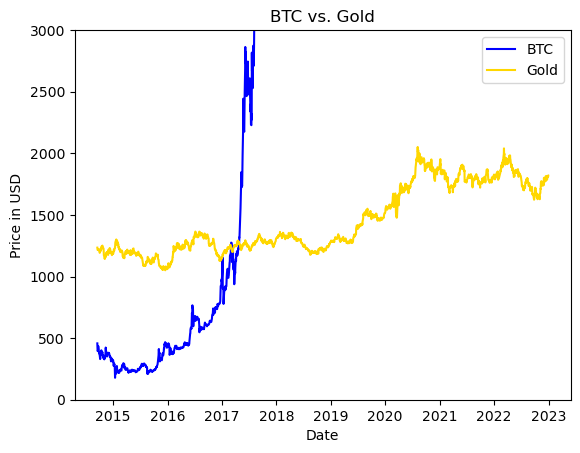

In [59]:
zoomed_in(df)

$H_0$: There is no correlation between the BTC and Gold price

$H_a$: There is a correlation between the BTC and Gold price

$\alpha$ = 0.05

In [60]:
α = 0.05
# Calculate the Pearson's correlation coefficient
r, p = pearsonr(df['btc_price'], df['gold_price'])

print("Pearson's correlation coefficient:", r)
print("p-value:", p)

if p < α:
    print('We reject the null hypothesis') 
else:
    print('We fail to reject the null hypothesis')

Pearson's correlation coefficient: 0.7642495379265786
p-value: 0.0
We reject the null hypothesis


**Takeaways** 

We reject the null hypothesis meaning there is a correlation between BTC and Gold have a positive correlation. With a 76% poistive correlation making it somewhat strong. 

### **3. How does the volatility of BTC compare with that of the DJI and Gold?**

In [61]:
btc_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,22939.398438,25371367758
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,21819.039062,32572572185
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,21651.183594,27078406594


In [62]:
def volatility(year):
    '''
    This function is calling the asset_price function from acquire.py, then calculating the
    percent change of the close column. After, we calculate the standard deviation for the 
    volatility. Printing out the result and the plotting it.
    '''
    btc_df, gold_df, dji_df = asset_price(year)
    
    # Calculate daily returns for each
    btc_returns = btc_df['Close'].pct_change()
    dji_returns = dji_df['Close'].pct_change()
    gold_returns = gold_df['Close'].pct_change()
    
    # Calculate the standard deviation of daily returns
    btc_volatility = btc_returns.std()
    dji_volatility = dji_returns.std()
    gold_volatility = gold_returns.std()
    
     # Compare the volatilities
    print("BTC Volatility:", btc_volatility)
    print("DJI Volatility:", dji_volatility)
    print("Gold Volatility:", gold_volatility)

    #plot the results
    btc_returns.plot(c = 'black')
    dji_returns.plot(c = 'orange')
    gold_returns.plot(c = 'dodgerblue')
    plt.xlim('2014-09-17', '2023-01-01')
    plt.ylabel('Daily Percent')
    plt.title('Volatility')
    plt.legend(['BTC','DJI', 'GOLD'], loc = 'lower left')
    plt.show()

In [63]:
'''def volatility(year, assets=['BTC', 'GOLD', 'DJI'], start_date='2014-09-17', end_date='2023-01-01'):
    This function calculates the volatility of a list of assets by retrieving data from asset_price function,
    calculating daily percent change of the close column, and then calculating the standard deviation of the daily returns. 
    The function returns a dictionary of asset symbols and their corresponding volatilities, and also plots a histogram of
    the daily returns for each asset.
    
    returns = {}
    volatilities = {}
    
    for asset in assets:
        df = asset_price(year)
        asset_returns = df['Close'].pct_change()
        asset_volatility = asset_returns.std()
        returns[asset] = asset_returns
        volatilities[asset] = asset_volatility
        
    # Plot the results
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), sharex=True)
    
    for asset in assets:
        axs[0].plot(returns[asset], label=asset)
        axs[1].hist(returns[asset], bins=50, alpha=0.5, label=asset, density=True)
    
    axs[0].set_ylabel('Daily Percent')
    axs[0].set_title('Volatility')
    axs[0].legend(loc='upper left')
    
    axs[1].set_xlabel('Daily Percent')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc='upper left')
    
    plt.xlim(start_date, end_date)
    plt.show()
    
    return volatilities
'''

"def volatility(year, assets=['BTC', 'GOLD', 'DJI'], start_date='2014-09-17', end_date='2023-01-01'):\n    This function calculates the volatility of a list of assets by retrieving data from asset_price function,\n    calculating daily percent change of the close column, and then calculating the standard deviation of the daily returns. \n    The function returns a dictionary of asset symbols and their corresponding volatilities, and also plots a histogram of\n    the daily returns for each asset.\n    \n    returns = {}\n    volatilities = {}\n    \n    for asset in assets:\n        df = asset_price(year)\n        asset_returns = df['Close'].pct_change()\n        asset_volatility = asset_returns.std()\n        returns[asset] = asset_returns\n        volatilities[asset] = asset_volatility\n        \n    # Plot the results\n    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), sharex=True)\n    \n    for asset in assets:\n        axs[0].plot(returns[asset], label=asset)\n       

In [64]:
# fix the for loop 
#volatility(2010, assets=['BTC', 'GOLD', 'DJI'], start_date='2014-09-17', end_date='2023-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BTC Volatility: 0.03816496621162785
DJI Volatility: 0.010854783277123137
Gold Volatility: 0.010191738788816374


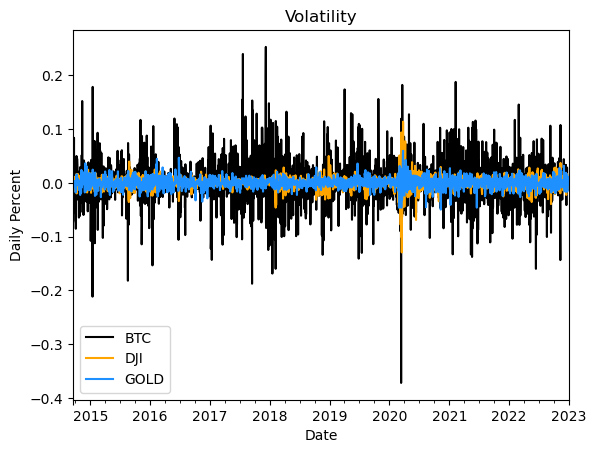

In [65]:
volatility(2010)

In [66]:
# Calculate daily returns for each
btc_returns = btc_df['Close'].pct_change()
dji_returns = dji_df['Close'].pct_change()
gold_returns = gold_df['Close'].pct_change()

In [67]:
# Calculate the standard deviation of daily returns
btc_volatility = btc_returns.std()
dji_volatility = dji_returns.std()
gold_volatility = gold_returns.std()

In [68]:
# Compare the volatilities
print("BTC Volatility:", btc_volatility)
print("DJI Volatility:", dji_volatility)
print("Gold Volatility:", gold_volatility)

BTC Volatility: 0.03816496621162785
DJI Volatility: 0.010854783277123137
Gold Volatility: 0.010191738788816374


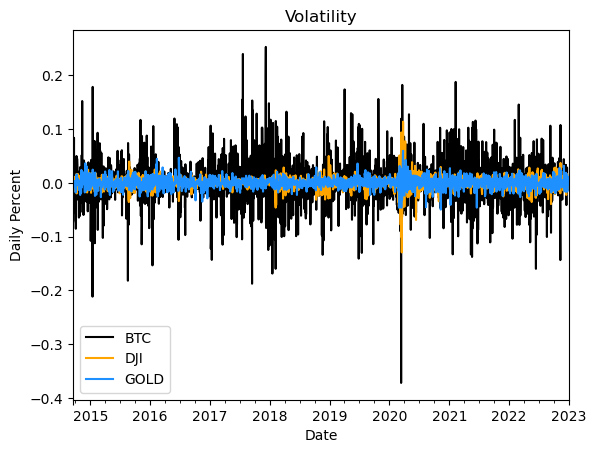

In [69]:
btc_returns.plot(c = 'black')
dji_returns.plot(c = 'orange')
gold_returns.plot(c = 'dodgerblue')
plt.xlim('2014-09-17', '2023-01-01')
plt.ylabel('Daily Percent')
plt.title('Volatility')
plt.legend(['BTC','DJI', 'GOLD'], loc = 'lower left')
plt.show()

**Takeaways**

We see from the chart that BTC is very volatile compared to the DJI and Gold. 

## Modeling

In [70]:
def evaluate(target_var, validate, yhat_df):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [71]:
def plot_and_eval(target_var, train, validate, yhat_df):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var, validate, yhat_df)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [72]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [73]:
def append_eval_df(validate, yhat_df, model_type, target_var):
    '''
    This function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var,validate, yhat_df)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True) 

In [74]:
def make_baseline_predictions(validate, btc_predictions=None):
    yhat_df = pd.DataFrame({'btc_price': btc_predictions},
                          index=validate.index)
    return yhat_df

### Resplit BTC data

In [75]:
def resplit_btc(btc_df):
    '''
    
    '''
    # preparing dataframe
    btc_df = btc_df['Adj Close']
    btc_df = pd.DataFrame(btc_df)
    btc_df.index.name = 'date'
    btc_df.rename(columns={'Adj Close': 'btc_price'}, inplace= True)
    
    #splitting
    train_size = int(round(btc_df.shape[0] * 0.6))
    validate_size = int(round(btc_df.shape[0] * 0.2))
    test_size = int(round(btc_df.shape[0] * 0.2))
    
    validate_end_index = train_size + validate_size
    
    train = btc_df[:train_size]
    validate = btc_df[train_size:validate_end_index]
    test = btc_df[validate_end_index:]
    
    return btc_df, train, validate, test

In [77]:
btc_df, train, validate, test = resplit_btc(btc_df)
train.shape[0], validate.shape[0], test.shape[0]

(1843, 614, 614)

In [ ]:
btc_df = btc_df['Adj Close']
btc_df = pd.DataFrame(btc_df)
btc_df.index.name = 'date'
btc_df.rename(columns={'Adj Close': 'btc_price'}, inplace= True)

In [ ]:
btc_df.head()

In [ ]:
btc_df.shape

In [ ]:
train_size = int(round(btc_df.shape[0] * 0.6))
validate_size = int(round(btc_df.shape[0] * 0.2))
test_size = int(round(btc_df.shape[0] * 0.2))
train_size, validate_size, test_size

In [ ]:
len(btc_df) == train_size + validate_size + test_size

In [ ]:
validate_end_index = train_size + validate_size
validate_end_index

In [ ]:
train = btc_df[:train_size]
validate = btc_df[train_size:validate_end_index]
test = btc_df[validate_end_index:]

In [ ]:
train.shape[0], validate.shape[0], test.shape[0]

In [ ]:
len(train) + len(validate) + len(test) == len(btc_df)

### Baseline model

In [ ]:
def baseline_model(train):
    '''
    
    '''
    period = 50
    train.rolling(period).mean()
    
    rolling_btc = round(train['btc_price'].rolling(period).mean()[-1], 2)
    
    yhat_df = make_baseline_predictions(rolling_btc)
    
    return yhat_df

In [79]:
period = 50
train.rolling(period).mean()

,btc_price
date,
2014-09-17,NaN
2014-09-18,NaN
2014-09-19,NaN
2014-09-20,NaN
2014-09-21,NaN
...,...
2019-09-29,10058.999062
2019-09-30,9994.404844
2019-10-01,9933.618047


In [80]:
rolling_btc = round(train['btc_price'].rolling(period).mean()[-1], 2)

print(rolling_btc)

9847.73


In [81]:
yhat_df = make_baseline_predictions(validate, rolling_btc)
yhat_df

,btc_price
date,
2019-10-04,9847.73
2019-10-05,9847.73
2019-10-06,9847.73
2019-10-07,9847.73
2019-10-08,9847.73
...,...
2021-06-04,9847.73
2021-06-05,9847.73
2021-06-06,9847.73


btc_price -- RMSE: 20028


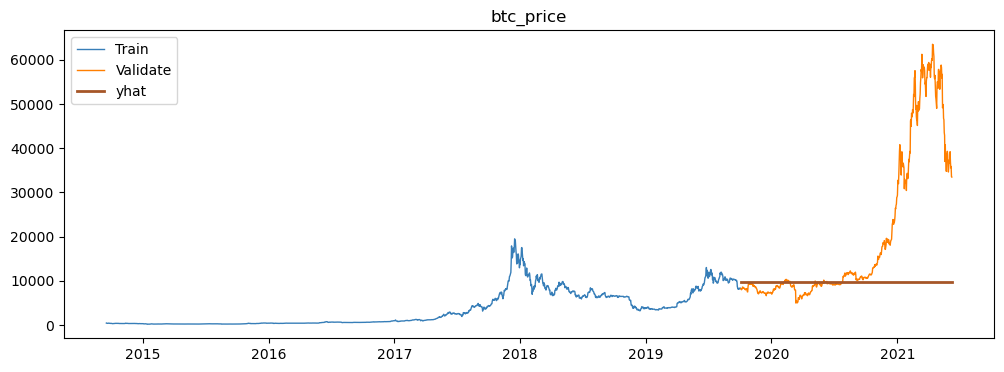

In [82]:
plot_and_eval('btc_price', train, validate, yhat_df)

In [83]:
train['btc_price_rolling_avg'] = train['btc_price'].rolling(window=50).mean()


<AxesSubplot:xlabel='date'>

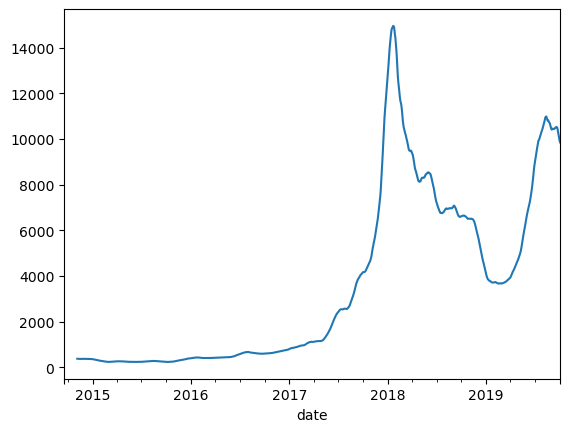

In [84]:
train['btc_price_rolling_avg'].plot()

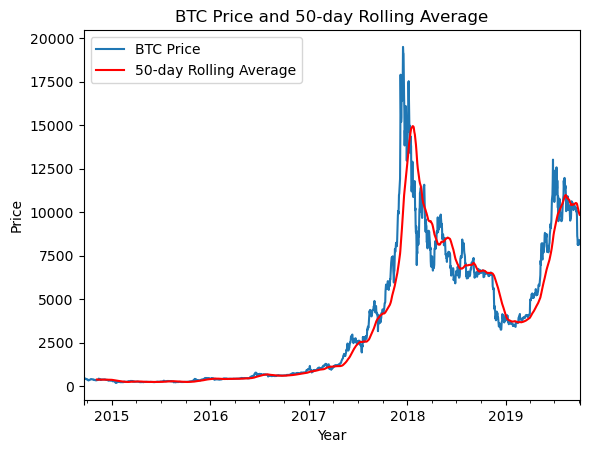

In [85]:
ax = train['btc_price'].plot(label='BTC Price')
train['btc_price_rolling_avg'].plot(ax=ax, label='50-day Rolling Average', color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('BTC Price and 50-day Rolling Average')
plt.show()


In [86]:
# work on eval_df df into a function to have all models

In [87]:
append_eval_df(validate, yhat_df, model_type = '50d_moving_avg', target_var = 'btc_price')

,model_type,target_var,rmse
0,50d_moving_avg,btc_price,20028.0


In [88]:
eval_df = append_eval_df(validate, yhat_df, model_type = '50d_moving_avg', target_var = 'btc_price')

eval_df

,model_type,target_var,rmse
0,50d_moving_avg,btc_price,20028.0


In [89]:
periods = [30, 90, 100, 180, 200]

for p in periods: 
    rolling_btc = round(train['btc_price'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(validate, rolling_btc)
    model_type = str(p) + '_day_moving_avg'
    eval_df = append_eval_df(validate, yhat_df, model_type = model_type,
                                target_var = 'btc_price')

In [90]:
eval_df.sort_values('rmse').reset_index().drop(columns= 'index')

,model_type,target_var,rmse
0,100_day_moving_avg,btc_price,19755.0
1,90_day_moving_avg,btc_price,19815.0
2,50d_moving_avg,btc_price,20028.0
3,30_day_moving_avg,btc_price,20143.0
4,180_day_moving_avg,btc_price,20486.0
5,200_day_moving_avg,btc_price,20743.0


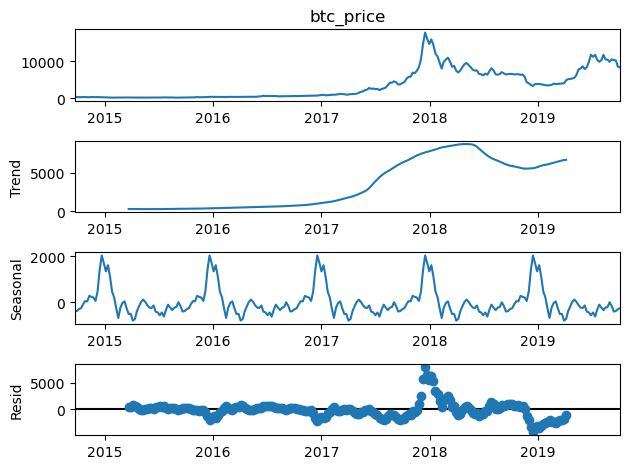

In [91]:
sm.tsa.seasonal_decompose(train['btc_price'].resample('W').mean()).plot()
plt.show()

### Holts Winter Linear

In [92]:
def holts_linear(col,validate):
    '''
    
    '''
    # create our Holt Object
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)   
    
    yhat_df = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df = pd.DataFrame({'btc_price': yhat_df},
                          index=validate.index)
    return yhat_df

In [93]:
yhat_df = holts_linear('btc_price', validate)
yhat_df

,btc_price
date,
2019-10-04,8260.604615
2019-10-05,8260.553753
2019-10-06,8260.503399
2019-10-07,8260.453548
2019-10-08,8260.404196
...,...
2021-06-04,8255.529533
2021-06-05,8255.529421
2021-06-06,8255.529311


In [ ]:
col = 'btc_price' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)
model = model.fit(optimized=True)

In [ ]:
yhat_df = model.predict(start = validate.index[0],
                              end = validate.index[-1])

btc_price -- RMSE: 20883


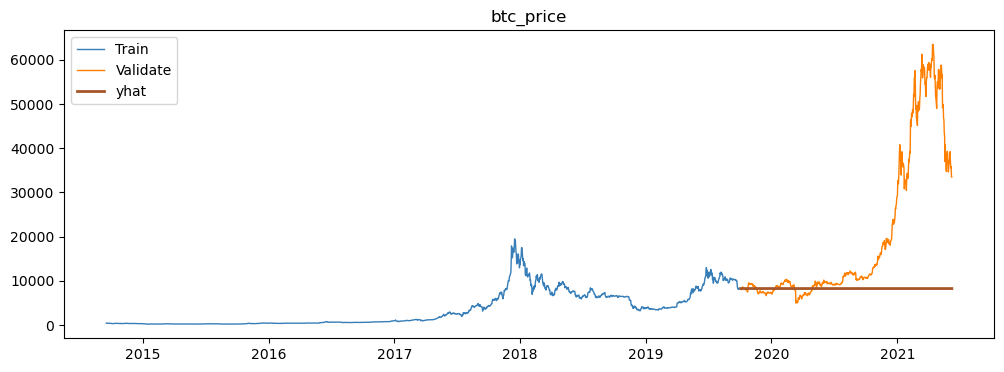

In [94]:
plot_and_eval('btc_price', train, validate, yhat_df)

btc_price -- RMSE: 20883


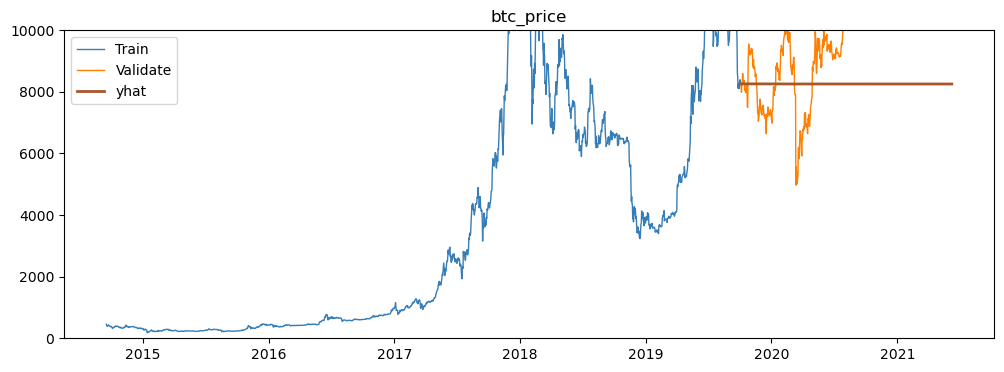

In [95]:
target_var= 'btc_price'

plt.figure(figsize = (12,4))
plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
plt.legend()
plt.title(target_var)
rmse = evaluate(target_var, validate, yhat_df)
print(target_var, '-- RMSE: {:.0f}'.format(rmse))
plt.ylim(0,10000)
plt.show()

In [98]:
eval_df = append_eval_df(validate, yhat_df, model_type = 'holts_optimized', 
                            target_var = 'btc_price')

eval_df

,model_type,target_var,rmse
0,50d_moving_avg,btc_price,20028.0
1,30_day_moving_avg,btc_price,20143.0
2,90_day_moving_avg,btc_price,19815.0
3,100_day_moving_avg,btc_price,19755.0
4,180_day_moving_avg,btc_price,20486.0
5,200_day_moving_avg,btc_price,20743.0
6,holts_optimized,btc_price,20883.0


In [99]:
def holts_seasonal(train, validate):
    '''
    
    '''
    hst_price_fit4 = ExponentialSmoothing(train.btc_price, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()
    
    yhat_list = hst_price_fit4.forecast(validate.shape[0]).tolist()
    yhat_df = pd.DataFrame({'btc_price': yhat_list}, index=validate.index)
    
    return yhat_df

In [100]:
yhat_df = holts_seasonal(train, validate)
yhat_df

,btc_price
date,
2019-10-04,8258.014889
2019-10-05,8356.827146
2019-10-06,8325.929197
2019-10-07,8351.222802
2019-10-08,8449.602730
...,...
2021-06-04,9155.990011
2021-06-05,9308.742201
2021-06-06,9191.326797


In [101]:
hst_price_fit1 = ExponentialSmoothing(train.btc_price, seasonal_periods=365, trend='add', seasonal='add').fit()
hst_price_fit2 = ExponentialSmoothing(train.btc_price, seasonal_periods=365, trend='add', seasonal='mul').fit()
hst_price_fit3 = ExponentialSmoothing(train.btc_price, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
hst_price_fit4 = ExponentialSmoothing(train.btc_price, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

In [102]:
results_price = pd.DataFrame({'model':['hst_price_fit1','hst_price_fit2','hst_price_fit3','hst_price_fit4'],
                              'SSE':[hst_price_fit1.sse, hst_price_fit2.sse, hst_price_fit3.sse, hst_price_fit4.sse]})
results_price      

,model,SSE
0,hst_price_fit1,1.273852e+08
1,hst_price_fit2,9.221888e+07
2,hst_price_fit3,1.198747e+08
3,hst_price_fit4,9.220889e+07


In [103]:
results_price.sort_values(by='SSE')

,model,SSE
3,hst_price_fit4,9.220889e+07
1,hst_price_fit2,9.221888e+07
2,hst_price_fit3,1.198747e+08
0,hst_price_fit1,1.273852e+08


In [104]:
yhat_list = hst_price_fit4.forecast(validate.shape[0]).tolist()
yhat_df = pd.DataFrame({'btc_price': yhat_list}, index=validate.index)
yhat_df

,btc_price
date,
2019-10-04,8258.014889
2019-10-05,8356.827146
2019-10-06,8325.929197
2019-10-07,8351.222802
2019-10-08,8449.602730
...,...
2021-06-04,9155.990011
2021-06-05,9308.742201
2021-06-06,9191.326797


btc_price -- RMSE: 20630


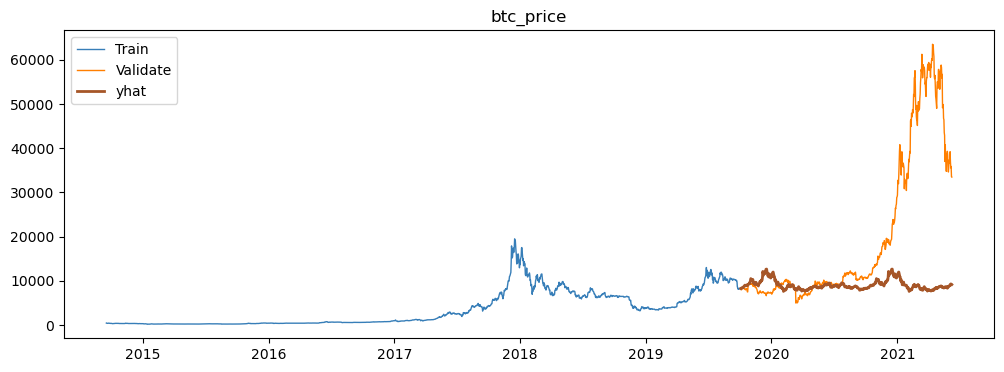

In [105]:
plot_and_eval('btc_price', train, validate, yhat_df)

btc_price -- RMSE: 20630


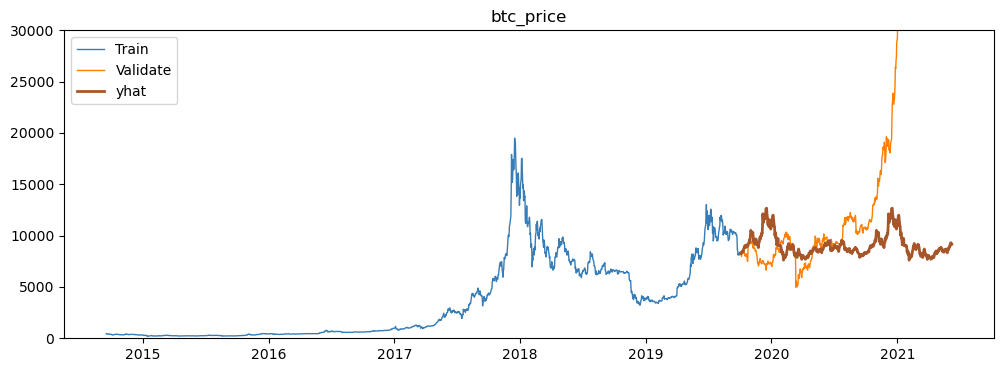

In [106]:
target_var= 'btc_price'

plt.figure(figsize = (12,4))
plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
plt.legend()
plt.title(target_var)
rmse = evaluate(target_var, validate, yhat_df)
print(target_var, '-- RMSE: {:.0f}'.format(rmse))
plt.ylim(0,30000)
plt.show()

In [108]:
eval_df = append_eval_df(validate, yhat_df, model_type = 'holts_seasonal_add_add', 
                            target_var = 'btc_price')

In [109]:
eval_df.sort_values('rmse')

,model_type,target_var,rmse
3,100_day_moving_avg,btc_price,19755.0
2,90_day_moving_avg,btc_price,19815.0
0,50d_moving_avg,btc_price,20028.0
1,30_day_moving_avg,btc_price,20143.0
4,180_day_moving_avg,btc_price,20486.0
7,holts_seasonal_add_add,btc_price,20630.0
5,200_day_moving_avg,btc_price,20743.0
6,holts_optimized,btc_price,20883.0


### Previous cycle

In [110]:
btc_df

,btc_price
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-02-08,22939.398438
2023-02-09,21819.039062
2023-02-10,21651.183594


In [111]:
def previous_cycle(btc_df):
    '''
    
    '''
    train = btc_df[:'2021-04-15']
    validate = btc_df['2021-04-16':'2022-03-15']
    test = btc_df['2022-03-16':]
    
    train.diff(365)
    
    yhat_df = train['2020-05-17':'2021-04-15'] + train.diff(365).mean()

    yhat_df.index = validate.index
    
    return yhat_df

In [112]:
previous_cycle(btc_df)

,btc_price
date,
2021-04-16,13636.932775
2021-04-17,13692.768713
2021-04-18,13695.231603
2021-04-19,13489.174963
2021-04-20,13047.955236
...,...
2022-03-11,64171.158361
2022-03-12,63859.646642
2022-03-13,67469.650549


In [113]:
train = btc_df[:'2021-04-15']
validate = btc_df['2021-04-16':'2022-03-15']
test = btc_df['2022-03-16':]

print(train.shape)
print(validate.shape)
print(test.shape)

(2403, 1)
(334, 1)
(334, 1)


In [114]:
train.diff(365)

,btc_price
date,
2014-09-17,NaN
2014-09-18,NaN
2014-09-19,NaN
2014-09-20,NaN
2014-09-21,NaN
...,...
2021-04-11,53345.881836
2021-04-12,52922.361328
2021-04-13,56658.419434


In [115]:
yhat_df = train['2020-05-17':'2021-04-15'] + train.diff(365).mean()
yhat_df

,btc_price
date,
2020-05-17,13636.932775
2020-05-18,13692.768713
2020-05-19,13695.231603
2020-05-20,13489.174963
2020-05-21,13047.955236
...,...
2021-04-11,64171.158361
2021-04-12,63859.646642
2021-04-13,67469.650549


In [116]:
train.diff(365).mean()

btc_price    3966.193517
dtype: float64

In [117]:
# yhat_df.index = validate.index

In [118]:
yhat_df.shape

(334, 1)

In [119]:
validate.shape 

(334, 1)

In [120]:
#yhat_df= yhat_df.iloc[:-1]

In [121]:
yhat_df.shape

(334, 1)

In [122]:
yhat_df

,btc_price
date,
2020-05-17,13636.932775
2020-05-18,13692.768713
2020-05-19,13695.231603
2020-05-20,13489.174963
2020-05-21,13047.955236
...,...
2021-04-11,64171.158361
2021-04-12,63859.646642
2021-04-13,67469.650549


In [123]:
pd.concat([yhat_df.head(1), validate.head(1)])

,btc_price
date,
2020-05-17,13636.932775
2021-04-16,61572.789062


In [124]:
yhat_df.index = validate.index

btc_price -- RMSE: 27613


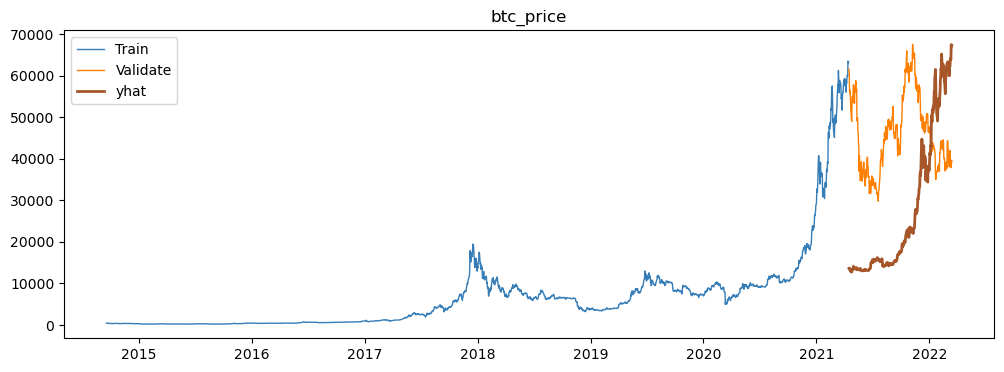

In [125]:
plot_and_eval('btc_price', train, validate, yhat_df)

In [126]:
eval_df = append_eval_df(validate, yhat_df, "previous_year", 'btc_price')

In [127]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
3,100_day_moving_avg,btc_price,19755.0
2,90_day_moving_avg,btc_price,19815.0
0,50d_moving_avg,btc_price,20028.0
1,30_day_moving_avg,btc_price,20143.0
4,180_day_moving_avg,btc_price,20486.0
7,holts_seasonal_add_add,btc_price,20630.0
5,200_day_moving_avg,btc_price,20743.0
6,holts_optimized,btc_price,20883.0
8,previous_year,btc_price,27613.0


### Test data subset

In [128]:
def test_model_split(btc_df):
    '''
    
    '''
    #splitting
    train_size = int(round(btc_df.shape[0] * 0.6))
    validate_size = int(round(btc_df.shape[0] * 0.2))
    test_size = int(round(btc_df.shape[0] * 0.2))
    
    validate_end_index = train_size + validate_size
    
    train = btc_df[:train_size]
    validate = btc_df[train_size:validate_end_index]
    test = btc_df[validate_end_index:]
    
    return train, validate, test

In [131]:
train, validate, test = test_model_split(btc_df)
train.shape, validate.shape, test.shape

((1843, 1), (614, 1), (614, 1))

In [130]:
train = btc_df[:train_size]
validate = btc_df[train_size:validate_end_index]
test = btc_df[validate_end_index:]

In [132]:
train.shape, validate.shape, test.shape

((1843, 1), (614, 1), (614, 1))

In [133]:
def make_test_predictions(train, validate_index=None, test_index=None):
    
    rolling_btc = round(train['btc_price'].rolling(100).mean()[-1], 2)
    
    # Create a DataFrame with the predictions and the corresponding index range
    index_range = pd.date_range(start=validate.index[0], end=test.index[-1], freq='D')
    yhat_df = pd.DataFrame({'btc_price': rolling_btc}, index=index_range)
    
    yhat_df = yhat_df['2021-06-09':]
    
    return yhat_df 

In [135]:
yhat_df = make_test_predictions(train, test)

In [ ]:
rolling_btc = round(train['btc_price'].rolling(100).mean()[-1], 2)

In [ ]:
rolling_btc

In [ ]:
yhat_df = make_test_predictions(rolling_btc)

In [136]:
yhat_df

,btc_price
2021-06-09,10394.91
2021-06-10,10394.91
2021-06-11,10394.91
2021-06-12,10394.91
2021-06-13,10394.91
...,...
2023-02-08,10394.91
2023-02-09,10394.91
2023-02-10,10394.91
2023-02-11,10394.91


In [137]:
test.head()

,btc_price
date,
2021-06-09,37345.121094
2021-06-10,36702.597656
2021-06-11,37334.398438
2021-06-12,35552.515625
2021-06-13,39097.859375


In [138]:
def final_plot(train, validate, test, yhat_df, target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [ ]:
yhat_df = yhat_df['2021-06-09':]

In [139]:
yhat_df.shape

(614, 1)

In [140]:
rmse_price = sqrt(mean_squared_error(test['btc_price'], 
                                       yhat_df['btc_price']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-price:  27436.26620219239


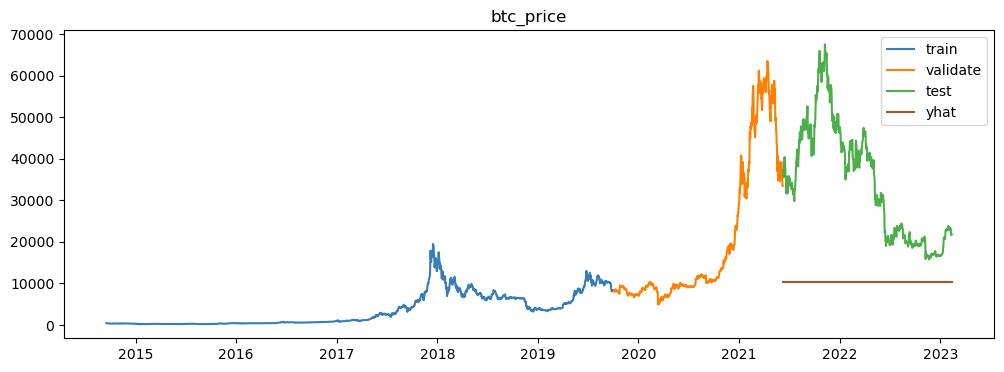

In [148]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-price: ', rmse_price)
final_plot(train, validate, test, yhat_df, 'btc_price')

In [149]:
def forecasting(btc_predictions=None):
    # Create a DataFrame with the predictions and the corresponding index range
    start_date = validate.index[0]
    end_date = test.index[-1] + pd.Timedelta(days=365)
    index_range = pd.date_range(start=start_date, end=end_date, freq='D')
    yhat_df = pd.DataFrame({'btc_price': btc_predictions}, index=index_range)
    
    return yhat_df

In [150]:
rolling_btc = round(train['btc_price'].rolling(100).mean()[-1], 2)

forecast = forecasting(rolling_btc)

In [151]:
forecast = forecast['2023':]
forecast

,btc_price
2023-01-01,10394.91
2023-01-02,10394.91
2023-01-03,10394.91
2023-01-04,10394.91
2023-01-05,10394.91
...,...
2024-02-08,10394.91
2024-02-09,10394.91
2024-02-10,10394.91
2024-02-11,10394.91


In [152]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

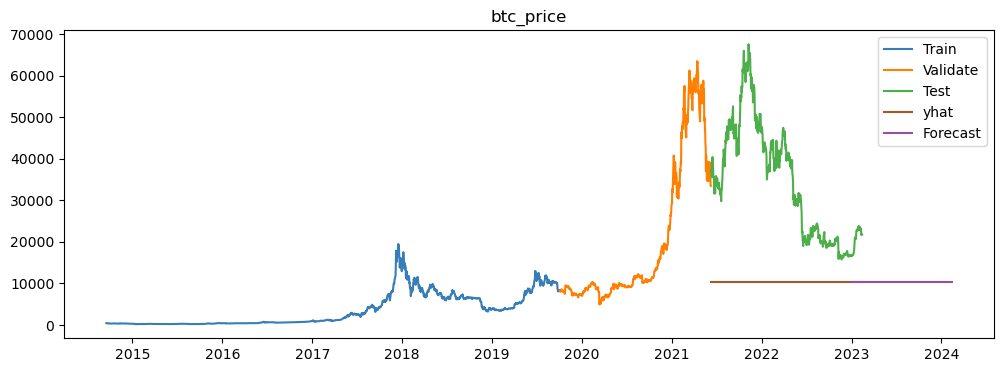

In [153]:
final_plot('btc_price')

In [154]:
def final_plot_zoomed(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.ylim(0,20000)
    plt.show()

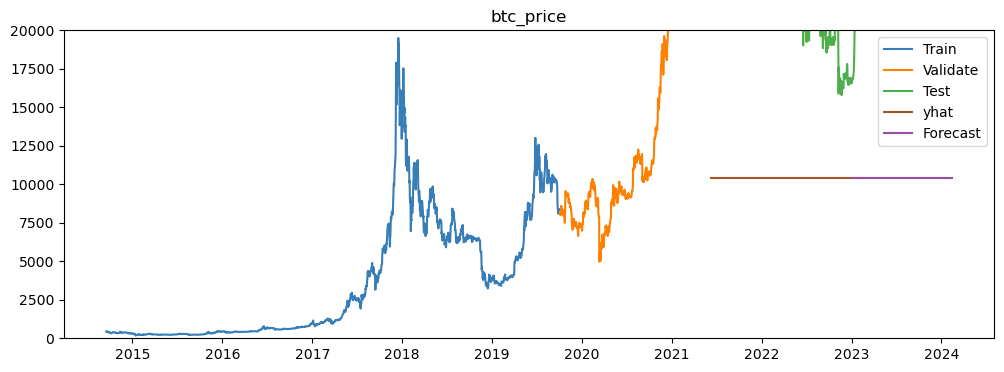

In [155]:
final_plot_zoomed('btc_price')